In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
import nltk
import string
from itertools import chain

2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

In [3]:
df_description = pd.read_csv('/content/drive/MyDrive/Genre Classification Dataset/description.txt', 
                           engine ='python', header = None, encoding='UTF-8')
df_description.reset_index(drop=True, inplace=True)
df_description.head()

,0
0,Train data:
1,ID ::: TITLE ::: GENRE ::: DESCRIPTION
2,ID ::: TITLE ::: GENRE ::: DESCRIPTION
3,ID ::: TITLE ::: GENRE ::: DESCRIPTION
4,ID ::: TITLE ::: GENRE ::: DESCRIPTION


----

### test_data

In [4]:
df_test_data = pd.read_csv('/content/drive/MyDrive/Genre Classification Dataset/test_data.txt', 
                           sep = ' ::: ', index_col = 0, engine ='python', header = None, encoding='UTF-8')
df_test_data.columns = ['TITLE','DESCRIPTION']
df_test_data.reset_index(drop=True, inplace=True)
df_test_data.head()

,TITLE,DESCRIPTION
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family o...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his..."
4,Er nu zhai (1955),Before he was known internationally as a marti...


In [5]:
if sum(list(df_test_data.isnull().sum())) == 0:
    print('\033[1m' + 'NaN-строки отсутствуют')
else:
    print('\033[1m' + 'NaN-строки присутствуют в количестве:'+'\033[0m')
    print(df_test_data.isnull().sum())

NaN-строки отсутствуют


In [6]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54200 non-null  object
 1   DESCRIPTION  54200 non-null  object
dtypes: object(2)
memory usage: 847.0+ KB


In [7]:
df_test_data.describe()

,TITLE,DESCRIPTION
count,54200,54200
unique,54200,54072
top,The Jeweled Heart Murders (2016),Grammy - music award of the American academy o...
freq,1,10


In [8]:
# дубликаты в столбце DESCRIPTION
ids = df_test_data['DESCRIPTION']
print('Количество идентичных записей в столбце DESCRIPTION =', 
      df_test_data[ids.isin(ids[ids.duplicated()])].index.nunique())
df_test_data[ids.isin(ids[ids.duplicated()])].sort_values('DESCRIPTION').head()

Количество идентичных записей в столбце DESCRIPTION = 203


,TITLE,DESCRIPTION
27594,The 31st Annual People's Choice Awards (2005),"""People' s Choice Awards"" - American award, th..."
33787,The 26th Annual People's Choice Awards (2000),"""People' s Choice Awards"" - American award, th..."
21428,The 25th Annual People's Choice Awards (1999),"""People' s Choice Awards"" - American award, th..."
15156,The 30th Annual People's Choice Awards (2004),"""People' s Choice Awards"" - American award, th..."
11257,The 12th Annual People's Choice Awards (1986),"""People' s Choice Awards"" - American award, th..."


In [9]:
# стоп-слова
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
    'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'shold',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
]

In [10]:
nltk.download('punkt', download_dir='.')

[nltk_data] Downloading package punkt to ....
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
def tokenize_text(raw_text: str):
    """Функция для токенизации текста
    
    :param raw_text: исходная текстовая строка
    """
    tokenized_str = nltk.word_tokenize(raw_text)
    tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]
    filtered_tokens = [i for i in tokens if ( i not in stop_words )]
    return filtered_tokens

# применяем функцию в датафрейму с помощью метода .apply()
tokenized_tweets= df_test_data.DESCRIPTION.apply(tokenize_text)

# добавляем новую колонку в исходный датафрейм
df_test_data = df_test_data.assign(
    tokenized=tokenized_tweets
)
from itertools import chain
print(f"Уникальных токенов {len(set(chain.from_iterable(df_test_data['tokenized'].to_list())))}.")

Уникальных токенов 147539.


----

### test_data_solution

In [12]:
df_test_data_solution = pd.read_csv('/content/drive/MyDrive/Genre Classification Dataset/test_data_solution.txt', 
                           sep = ' ::: ', index_col = 0, engine ='python', header = None, encoding='UTF-8')
df_test_data_solution.columns = ['TITLE','GENRE','DESCRIPTION']
df_test_data_solution.reset_index(drop=True, inplace=True)
df_test_data_solution.head()

,TITLE,GENRE,DESCRIPTION
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,Er nu zhai (1955),drama,Before he was known internationally as a marti...


In [13]:
if sum(list(df_test_data_solution.isnull().sum())) == 0:
    print('\033[1m' + 'NaN-строки отсутствуют')
else:
    print('\033[1m' + 'NaN-строки присутствуют в количестве:'+'\033[0m')
    print(df_test_data_solution.isnull().sum())

NaN-строки отсутствуют


In [14]:
df_test_data_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54200 non-null  object
 1   GENRE        54200 non-null  object
 2   DESCRIPTION  54200 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [15]:
df_test_data_solution.describe()

,TITLE,GENRE,DESCRIPTION
count,54200,54200,54200
unique,54200,27,54072
top,The Jeweled Heart Murders (2016),drama,Grammy - music award of the American academy o...
freq,1,13612,10


In [16]:
print(f"Количество возможных классификаций по жанрам в df_test_data_solution = \
{df_test_data_solution['GENRE'].nunique()}")

Количество возможных классификаций по жанрам в df_test_data_solution = 27


In [17]:
# дубликаты в столбце DESCRIPTION
ids = df_test_data_solution['DESCRIPTION']
print('Количество идентичных записей в столбце DESCRIPTION =', 
      df_test_data_solution[ids.isin(ids[ids.duplicated()])].index.nunique())
df_test_data_solution[ids.isin(ids[ids.duplicated()])].sort_values('DESCRIPTION').head()

Количество идентичных записей в столбце DESCRIPTION = 203


,TITLE,GENRE,DESCRIPTION
27594,The 31st Annual People's Choice Awards (2005),family,"""People' s Choice Awards"" - American award, th..."
33787,The 26th Annual People's Choice Awards (2000),family,"""People' s Choice Awards"" - American award, th..."
21428,The 25th Annual People's Choice Awards (1999),family,"""People' s Choice Awards"" - American award, th..."
15156,The 30th Annual People's Choice Awards (2004),family,"""People' s Choice Awards"" - American award, th..."
11257,The 12th Annual People's Choice Awards (1986),family,"""People' s Choice Awards"" - American award, th..."


In [18]:
# применяем функцию в датафрейму с помощью метода .apply()
tokenized_tweets= df_test_data_solution.DESCRIPTION.apply(tokenize_text)

# добавляем новую колонку в исходный датафрейм
df_test_data_solution = df_test_data_solution.assign(
    tokenized=tokenized_tweets
)
print(f"Уникальных токенов {len(set(chain.from_iterable(df_test_data_solution['tokenized'].to_list())))}.")

Уникальных токенов 147539.


---

### df_train_data

In [19]:
df_train_data = pd.read_csv('/content/drive/MyDrive/Genre Classification Dataset/train_data.txt', 
                           sep = ' ::: ', index_col = 0, engine ='python', header = None, encoding='UTF-8')
df_train_data.columns = ['TITLE','GENRE','DESCRIPTION']
df_train_data.reset_index(drop=True, inplace=True)
df_train_data.head()

,TITLE,GENRE,DESCRIPTION
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [20]:
if sum(list(df_train_data.isnull().sum())) == 0:
    print('\033[1m' + 'NaN-строки отсутствуют')
else:
    print('\033[1m' + 'NaN-строки присутствуют в количестве:'+'\033[0m')
    print(df_train_data.isnull().sum())

NaN-строки отсутствуют


In [21]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [22]:
df_train_data.describe()

,TITLE,GENRE,DESCRIPTION
count,54214,54214,54214
unique,54214,27,54086
top,Das Sommerhaus (2014),drama,Grammy - music award of the American academy o...
freq,1,13613,12


In [23]:
print(f"Количество возможных классификаций по жанрам в df_test_data_solution = \
{df_train_data['GENRE'].nunique()}")

Количество возможных классификаций по жанрам в df_test_data_solution = 27


In [24]:
# дубликаты в столбце DESCRIPTION
ids = df_train_data['DESCRIPTION']
print('Количество идентичных записей в столбце DESCRIPTION =', 
      df_train_data[ids.isin(ids[ids.duplicated()])].index.nunique())
df_train_data[ids.isin(ids[ids.duplicated()])].sort_values('DESCRIPTION').head()

Количество идентичных записей в столбце DESCRIPTION = 204


,TITLE,GENRE,DESCRIPTION
27304,The 18th Annual People's Choice Awards (1992),family,"""People' s Choice Awards"" - American award, th..."
39037,The 28th Annual People's Choice Awards (2002),family,"""People' s Choice Awards"" - American award, th..."
17577,The 3rd Annual People's Choice Awards (1977),reality-tv,"""People' s Choice Awards"" - American award, th..."
17765,The 5th Annual People's Choice Awards (1979),reality-tv,"""People' s Choice Awards"" - American award, th..."
35641,The 38th Annual People's Choice Awards (2012),talk-show,"""People' s Choice Awards"" - American award, th..."


In [25]:
# применяем функцию в датафрейму с помощью метода .apply()
tokenized_tweets= df_train_data.DESCRIPTION.apply(tokenize_text)

# добавляем новую колонку в исходный датафрейм
df_train_data = df_train_data.assign(
    tokenized=tokenized_tweets
)
print(f"Уникальных токенов {len(set(chain.from_iterable(df_train_data['tokenized'].to_list())))}.")

Уникальных токенов 148252.


---

###### Создадим словарь уникальных слов из всех токенизированных описаний фильмов датасета train_data

In [26]:
# Список уникальных слов из train_data для формирования словаря
word_list = list(set(chain.from_iterable(df_train_data['tokenized'].to_list())))
word_list.sort()

In [27]:
# Количество слов в словаре
VOCAB_SIZE = len(set(chain.from_iterable(df_train_data['tokenized'].to_list()))) + 3

In [28]:
# Словарь - слово:индекс
word_index = dict(zip(word_list, range(len(word_list))))
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2

# Обратный словарь индекс:слово
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# последовательность индексов в текст
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# текст в последовательность индексов
def encode_review(text):
    words = text.lower().split()
    words = ['<START>'] + words
    idxs = [word_index.get(word, word_index['<UNKNOWN>']) for word in words]
    return idxs

### Проверка работы функций decode_review и encode_review
Протестируем функции `decode_review` и `encode_review`

In [29]:
# Синтетический пример
#text = 'hello world'
text = ' '.join(['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 
                 'documentary', 'drama', 'family', 'fantasy', 'game-show', 'history', 'horror', 
                 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 
                 'short', 'sport', 'talk-show', 'thriller', 'war', 'western'])

print(encode_review(text))
print(decode_review(encode_review(text)))

[1, 8888, 9386, 9428, 12590, 20560, 31617, 34829, 41351, 42361, 49180, 49333, 54710, 63190, 64114, 90784, 90808, 91070, 93099, 109507, 113461, 117349, 120839, 125296, 130420, 132916, 142647, 143672]
<START> action adult adventure animation biography comedy crime documentary drama family fantasy game-show history horror music musical mystery news reality-tv romance sci-fi short sport talk-show thriller war western


In [30]:
# Реальный пример из датасета
print('Исходный текст: \n{}\n'.format(df_train_data['DESCRIPTION'][1]))

print('Токенизированный исходный текст: \n{}\n'.format(' '.join(df_train_data['tokenized'][1])))

print('Example of a encoded review: \n{}\n'.format(encode_review(' '.join(df_train_data['tokenized'][1]))))

print('Example of a decoded review: \n{}'.format(decode_review([1, 23812, 122041, 99800, 66758, 110721, 35700, 
                                                                90671, 110721, 90673, 144967, 110664, 90673, 144967, 55903, 30531])))

Исходный текст: 
A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.

Токенизированный исходный текст: 
brother sister past incestuous relationship current murderous relationship murders women reject murders women get close

Example of a encoded review: 
[1, 23812, 122041, 99800, 66758, 110721, 35700, 90671, 110721, 90673, 144967, 110664, 90673, 144967, 55903, 30531]

Example of a decoded review: 
<START> brother sister past incestuous relationship current murderous relationship murders women reject murders women get close


### Приведение всех цепочек в датасете к одной длине с помощью паддинга
Одна цепочка это одно описание. А описания могут быть различной длины. 

Так как нам будет необходимо собирать из описаний батчи (группы цепочек), удобно все описания привести к одной длине с помощью падинга в конце (добавлением элементов `<PAD>`).

In [31]:
# Расммотрим стат. данные по количеству слов в описаниях
print('Максимально количество слов в столбце tokenized = {}\n'.
      format(df_train_data['tokenized'].apply(len).max()))
print('Минимальное количество слов в столбце tokenized = {}\n'.
      format(df_train_data['tokenized'].apply(len).min()))
print('Медианное количество слов в столбце tokenized = {}\n'.
      format(round(df_train_data['tokenized'].apply(len).median())))
print('Среднее значение количество слов в столбце tokenized = {}\n'.
      format(round(df_train_data['tokenized'].apply(len).mean())))

Максимально количество слов в столбце tokenized = 1483

Минимальное количество слов в столбце tokenized = 4

Медианное количество слов в столбце tokenized = 46

Среднее значение количество слов в столбце tokenized = 59



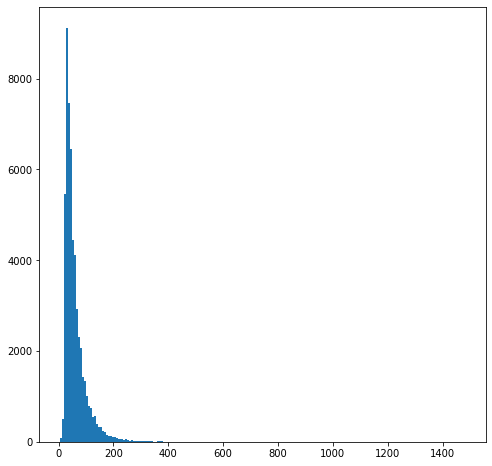

In [32]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(8, 8))
plt.hist(df_train_data['tokenized'].apply(len), bins = 200)
plt.show()

In [33]:
# Векторизация исходных данных
array_list = []
for row in df_train_data['tokenized'].values:
    array_list.append(encode_review(' '.join(row)))
train_data_array = np.array(array_list, dtype='object')

array_list = []
for row in df_test_data_solution['tokenized'].values:
    array_list.append(encode_review(' '.join(row)))
test_data_array = np.array(array_list, dtype='object')

array_list = []
for row in df_train_data['GENRE'].values:
    array_list.append(encode_review(row)[1])
train_labels_array = np.array(array_list, dtype='object')

array_list = []
for row in df_test_data_solution['GENRE'].values:
    array_list.append(encode_review(row)[1])
test_labels_array = np.array(array_list, dtype='object')

In [34]:
MAX_SEQ_LEN = 150 # Финальная длина последовательности

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data_array,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data_array,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

print("Length examples: {}".format([len(train_data[0]), len(train_data[1])]))
print('=====================================')
print("Entry example: {}".format(train_data[100]))

Length examples: [150, 150]
Entry example: [     1 102130  41351  27919 105100  47238  24182 103265  15701  41467
  23531  78458  48849  47517  44330 112422 105100  47238  88869 103265
  41621 103300  27678  74583  49225  56982 125690  58590  98376   6364
  37968  79225 132464  34952  57602  37568  78562  18005 106792  68602
  50773 136963  46607  47957 125397  64493  15701 103265  73061  41084
  33159 144560  80301  34654  58044  11952 128051  99569 123464  34905
  34200  32859 144036  47238 105750  18684  42055 102130 124543  47238
 130292  15701  41467 126152 141728 105037  68286  44118  68057  48281
  97127  47238  37568  34905  66660 100720  34905  34200  52794  47213
 138171 100720  66244  16724  37696  82447  41351 120997  15701 136486
 104371 113513  52061 128992 126957  33507  15032  40304 100720      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      

In [67]:
# Двунаправленная рекуррентная сеть
EMB_SIZE = 256 # Размер векторного представления (эмбеддинга)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(27, activation=tf.nn.softmax),
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 256)         37953280  
_________________________________________________________________
bidirectional_15 (Bidirectio (None, None, 512)         1050624   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 512)         1574912   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 512)               1574912   
_________________________________________________________________
dense_6 (Dense)              (None, 27)                13851     
Total params: 42,167,579
Trainable params: 42,167,579
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [37]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels_array[:10000]
partial_y_train = train_labels_array[10000:]

In [ ]:
# приведение числовых значений y_val, partial_y_train и test_labels_array в диапазон 0...26, поскольку изначальная векторизация присвоила элементам
# этих объектов значения индексов на основании общего словаря df_train_data['tokenized']

In [38]:
labels_list = list(set(train_labels_array))
labels_list.sort()
dict_labels = dict(zip(labels_list, range(len(labels_list))))
dict_labels

{8888: 0,
 9386: 1,
 9428: 2,
 12590: 3,
 20560: 4,
 31617: 5,
 34829: 6,
 41351: 7,
 42361: 8,
 49180: 9,
 49333: 10,
 54710: 11,
 63190: 12,
 64114: 13,
 90784: 14,
 90808: 15,
 91070: 16,
 93099: 17,
 109507: 18,
 113461: 19,
 117349: 20,
 120839: 21,
 125296: 22,
 130420: 23,
 132916: 24,
 142647: 25,
 143672: 26}

In [39]:
count = 0
for i in y_val:
    y_val[count] = dict_labels[i]
    count += 1

In [40]:
count = 0
for i in partial_y_train:
    partial_y_train[count] = dict_labels[i]
    count += 1

In [41]:
count = 0
for i in test_labels_array:
    test_labels_array[count] = dict_labels[i]
    count += 1

In [42]:
partial_x_train = np.asarray(partial_x_train).astype('float32')
partial_y_train = np.asarray(partial_y_train).astype('float32')
x_val = np.asarray(x_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
test_labels_array = np.asarray(test_labels_array).astype('float32')

In [59]:
BATCH_SIZE = 512
NUM_EPOCHS = 10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
87/87 [==============================] - 324s 4s/step - loss: 2.4564 - sparse_categorical_accuracy: 0.2850 - val_loss: 1.8629 - val_sparse_categorical_accuracy: 0.4609
Epoch 2/5
87/87 [==============================] - 311s 4s/step - loss: 1.6801 - sparse_categorical_accuracy: 0.5121 - val_loss: 1.7885 - val_sparse_categorical_accuracy: 0.4760
Epoch 3/5
87/87 [==============================] - 307s 4s/step - loss: 1.3339 - sparse_categorical_accuracy: 0.6137 - val_loss: 1.8848 - val_sparse_categorical_accuracy: 0.4720
Epoch 4/5
87/87 [==============================] - 302s 3s/step - loss: 1.0494 - sparse_categorical_accuracy: 0.6988 - val_loss: 2.0674 - val_sparse_categorical_accuracy: 0.4806
Epoch 5/5
87/87 [==============================] - 304s 3s/step - loss: 0.8418 - sparse_categorical_accuracy: 0.7543 - val_loss: 2.1814 - val_sparse_categorical_accuracy: 0.4609


In [60]:
results = model.evaluate(test_data, test_labels_array)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

1694/1694 [==============================] - 324s 191ms/step - loss: 2.1603 - sparse_categorical_accuracy: 0.4617
Test loss: 2.1603
Test accuracy: 46.17 %


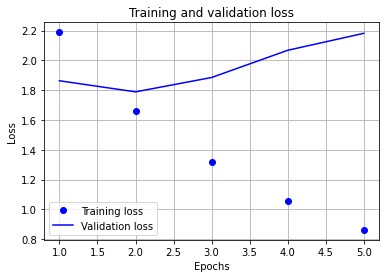

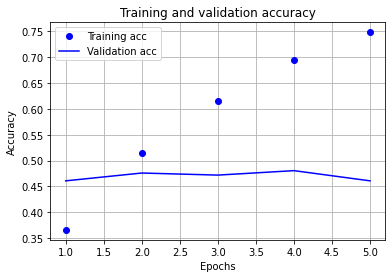

In [61]:
epochs = range(1, len(history.history['sparse_categorical_accuracy']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [66]:
#Проверка результатов
all_genres = df_train_data['GENRE'].unique()
all_genres.sort()
def predict_genre(model, sample_idx=None):
    if sample_idx == None:
        sample_idx = np.random.randint(test_data.shape[0])
    print('\n')
    print(f'Description:  {df_test_data.iloc[sample_idx, 1]}')
    print(f'              ------------')
    print(f'Actual genre:| {df_test_data_solution.iloc[sample_idx, 1]}')
    print(f'              ------------')
    print(f'Prediction:  | {all_genres[np.argmax(model.predict(test_data[sample_idx].reshape(1, -1)), axis=-1)][0]}')
    print(f'              ------------')

for _ in range(3):
    predict_genre(model)



Description:  Action takes place during one day - 9.09.1944. This is a day, when Bulgaria goes out from Nazi coalition and join to antifascist countries. The supporters of Nazi regime are still fighting back. The partisan detachments are coming soon from mountains. The film's young protagonist Mustafa is one of them. He will have to answer for himself important moral questions which the revolution asks of every man. He should decide for himself where exactly the boundary between justified and unjustified violence lies. This is a longest day in Mustafa life - the day of his coming of age. On this day he experiences his first doubt. Mustafa remembers a night when they had orders to kill a political instigator but his friend Matey has killed his child by mistake. Matey receives a light sentence but his guilty conscience makes him put an end to his life. Another young boy joins the troupe and receives his name. He acts without questioning orders and without displaying doubt. One of his t